# BREAST CANCER SEGMENTATION ON NUCLS DATASET
## SERHAN TÜRKAN
## M. UMUT BÖLÜK

# Part 0 - Intro

In [1]:
# Set number of GPUs
num_gpus = 1
# Set height and width to train model on
img_height, img_width = (256,256)

In [30]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import sys
import warnings
import matplotlib.pyplot as plt
import skimage.io                                     
import skimage.transform                              
from skimage.morphology import label             

import numpy as np
import pandas as pd

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import multi_gpu_model, plot_model
from keras import backend as K
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# Part 1 - Data Input

In [3]:
BATCH_SIZE = 10
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'qc/train/'
TEST_PATH = 'qc/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [4]:
train_ids = next(os.walk('qc/train/images/'))[2]
test_ids = next(os.walk('qc/test/images/'))[2]

In [5]:
from skimage.filters import threshold_otsu
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH,1),dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    img = imread( 'qc/train/images/' +id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT+40, IMG_WIDTH+40), mode='constant', preserve_range=True) 
    img=img[20:IMG_HEIGHT+20,20:IMG_WIDTH+20]#mode='constant'
    X_train[n] = img
    
    mask = imread('qc/train/masks/' + id_ )[:,:,:1]
    mask = resize(mask, (IMG_HEIGHT+40, IMG_WIDTH+40), mode='constant', preserve_range=True)
    mask=mask[20:IMG_HEIGHT+20,20:IMG_WIDTH+20]
    ## Cropping the frame for unwanted wrong results
    mask[mask<128]=0
    mask[mask>=128]=1
    mask=np.array(mask,dtype=bool)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 1308/1308 [00:47<00:00, 27.63it/s]


In [6]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread('qc/test/images/' +id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), clip=True, preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 436/436 [00:10<00:00, 41.67it/s]

Done!


## Visualize masks on the training data

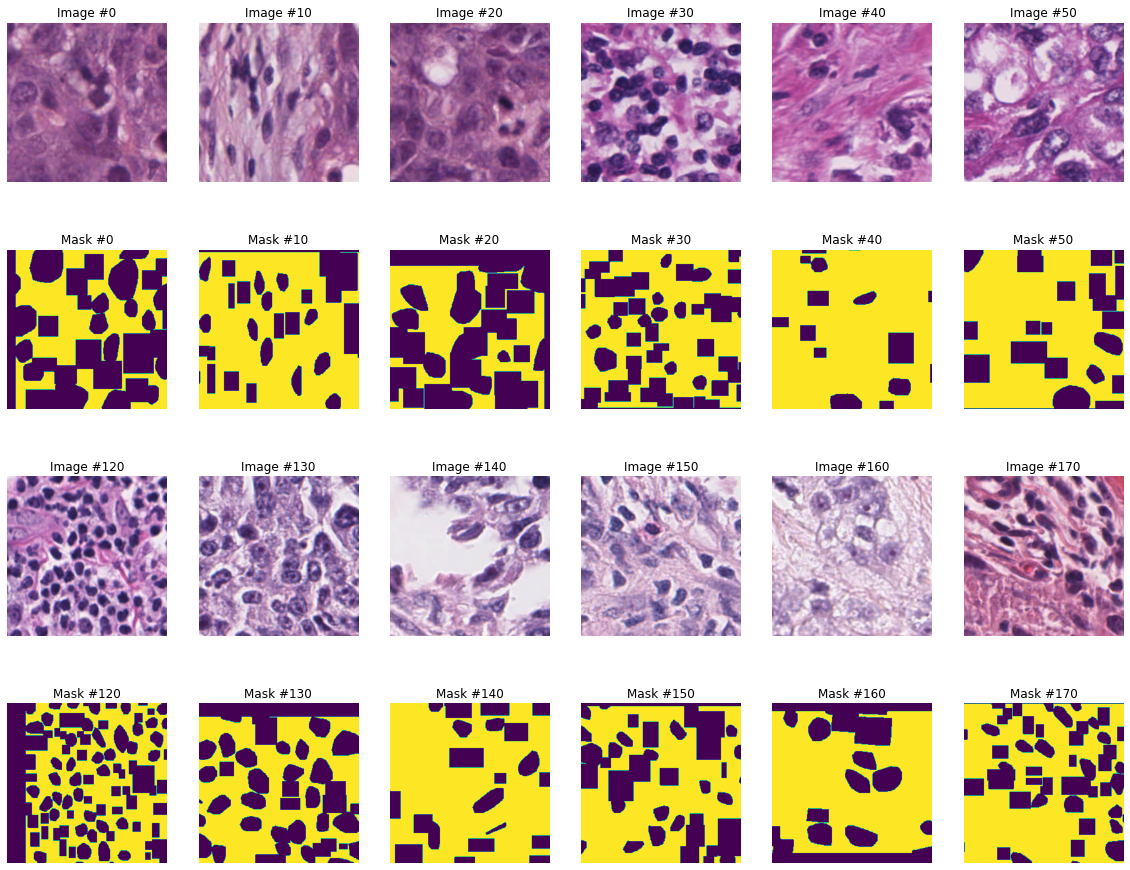

In [7]:
# Some of the train images and masks
plt.figure(figsize=(20,16))
x, y = 6,2
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
plt.show()

# Part 2 - Build model

In [8]:
# Design our model architecture here
def keras_model(img_width=256, img_height=256):
    '''
    Modified from https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/
    '''
    n_ch_exps = [4, 5, 6, 7, 8, 9]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer

    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (3, img_width, img_height)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_width, img_height, 3)

    inp = Input(shape=input_shape)
    encodeds = []

    # encoder
    enc = inp
    print(n_ch_exps)
    for l_idx, n_ch in enumerate(n_ch_exps):
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        enc = Dropout(0.1*l_idx,)(enc)
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        encodeds.append(enc)
        if n_ch < n_ch_exps[-1]:  #do not run max pooling on the last encoding/downsampling step
            enc = MaxPooling2D(pool_size=(2,2))(enc)
    
    # decoder
    dec = enc
    print(n_ch_exps[::-1][1:])
    decoder_n_chs = n_ch_exps[::-1][1:]
    for l_idx, n_ch in enumerate(decoder_n_chs):
        l_idx_rev = len(n_ch_exps) - l_idx - 2  #
        dec = Conv2DTranspose(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = concatenate([dec, encodeds[l_idx_rev]], axis=ch_axis)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = Dropout(0.1*l_idx)(dec)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)

    outp = Conv2DTranspose(filters=1, kernel_size=k_size, activation='sigmoid', padding='same', kernel_initializer='glorot_normal')(dec)

    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [9]:
# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [10]:
# Set some model compile parameters
optimizer = 'adam'
loss      = bce_dice_loss
metrics   = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

# Compile our model
model = keras_model(img_width=img_width, img_height=img_height)
model.summary()

if num_gpus > 1:
    model = multi_gpu_model(model, gpus=num_gpus)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[4, 5, 6, 7, 8, 9]
[8, 7, 6, 5, 4]
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
____________________________________________________

# Part 3 - Run model

In [11]:
def get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=0.1, batch_size=32, seed=seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator, X_train, X_test, Y_train, Y_test

In [12]:
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)
        #[metric for metric in self.params['metrics'] if not metric.startswith('Acc_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();

plot_losses = PlotLosses(figsize=(16, 4))

In [13]:
from tensorflow.python.keras import metrics
from tensorflow.python.keras.metrics import Metric
# parameters
batch_size = 16
earlystopper=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
checkpointer = ModelCheckpoint('model-weights.hdf5', verbose=1, save_best_only=True)
train_generator, test_generator, X_train, X_val, Y_train, Y_val = get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=0.1, batch_size=batch_size)

#Train the model
model.fit_generator(train_generator, validation_data=test_generator, validation_steps=batch_size/2, steps_per_epoch=len(X_train)/(batch_size*2), epochs=30,callbacks=[earlystopper, checkpointer])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
37/36 [==============================] - ETA: 0s - loss: 8.3558 - binary_accuracy: 0.4875
Epoch 00001: val_loss improved from inf to -0.20427, saving model to model-weights.hdf5
37/36 [==============================] - 149s 4s/step - loss: 8.3558 - binary_accuracy: 0.4875 - val_loss: -0.2043 - val_binary_accuracy: 0.6621
Epoch 2/30
37/36 [==============================] - ETA: 0s - loss: -0.2120 - binary_accuracy: 0.6285
Epoch 00002: val_loss improved from -0.20427 to -0.22598, saving model to model-weights.hdf5
37/36 [==============================] - 148s 4s/step - loss: -0.2120 - binary_accuracy: 0.6285 - val_loss: -0.2260 - val_binary_accuracy: 0.6701
Epoch 3/30
37/36 [==============================] - ETA: 0s - loss: -0.2284 - binary_accuracy: 0.6426
Epoch 00003: val_loss improved from -0.22598 to -0.24281, saving model to model-weights.hdf5
37/36 [==============================] - 153s 4s/step 

Epoch 25/30
37/36 [==============================] - ETA: 0s - loss: -0.4464 - binary_accuracy: 0.7784
Epoch 00025: val_loss improved from -0.45873 to -0.46143, saving model to model-weights.hdf5
37/36 [==============================] - 149s 4s/step - loss: -0.4464 - binary_accuracy: 0.7784 - val_loss: -0.4614 - val_binary_accuracy: 0.8111
Epoch 26/30
37/36 [==============================] - ETA: 0s - loss: -0.4501 - binary_accuracy: 0.7771
Epoch 00026: val_loss improved from -0.46143 to -0.47383, saving model to model-weights.hdf5
37/36 [==============================] - 148s 4s/step - loss: -0.4501 - binary_accuracy: 0.7771 - val_loss: -0.4738 - val_binary_accuracy: 0.8170
Epoch 27/30
37/36 [==============================] - ETA: 0s - loss: -0.4607 - binary_accuracy: 0.7824
Epoch 00027: val_loss improved from -0.47383 to -0.47663, saving model to model-weights.hdf5
37/36 [==============================] - 150s 4s/step - loss: -0.4607 - binary_accuracy: 0.7824 - val_loss: -0.4766 - va

In [14]:
# Save the model weights to a hdf5 file
if num_gpus > 1:
    #Refer to https://stackoverflow.com/questions/41342098/keras-load-checkpoint-weights-hdf5-generated-by-multiple-gpus
    #model.summary()
    model_out = model.layers[-2]  #get second last layer in multi_gpu_model i.e. model.get_layer('model_1')
else:
    model_out = model
model_out.save_weights(filepath="model-weights.hdf5")

# Part 4 - Evaluate output

## Visualize predictions on the validation data

In [15]:
# Reload the model
model_loaded = keras_model(img_width=img_width, img_height=img_height)
model_loaded.load_weights("model-weights.hdf5")

[4, 5, 6, 7, 8, 9]
[8, 7, 6, 5, 4]


In [16]:
# Predict on val
preds_val = model.predict(X_val, verbose=1)
# Threshold predictions
preds_val_t = (preds_val > 0.5)

5/5 [==============================] - 6s 1s/step


In [17]:
# Define IoU metric as a regular function, to manually check result
def cal_iou(A, B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou

In [18]:
# calcualte average iou of validation images, the result from tensorflow seems too high. 
iou=[]
for i in range(len(Y_val)):
    iou.append(cal_iou(np.squeeze(Y_val[i]), np.squeeze(preds_val_t[i])))
print('Average Validate IOU: {}'.format(round(np.mean(iou),2)))

Average Validate IOU: 0.76


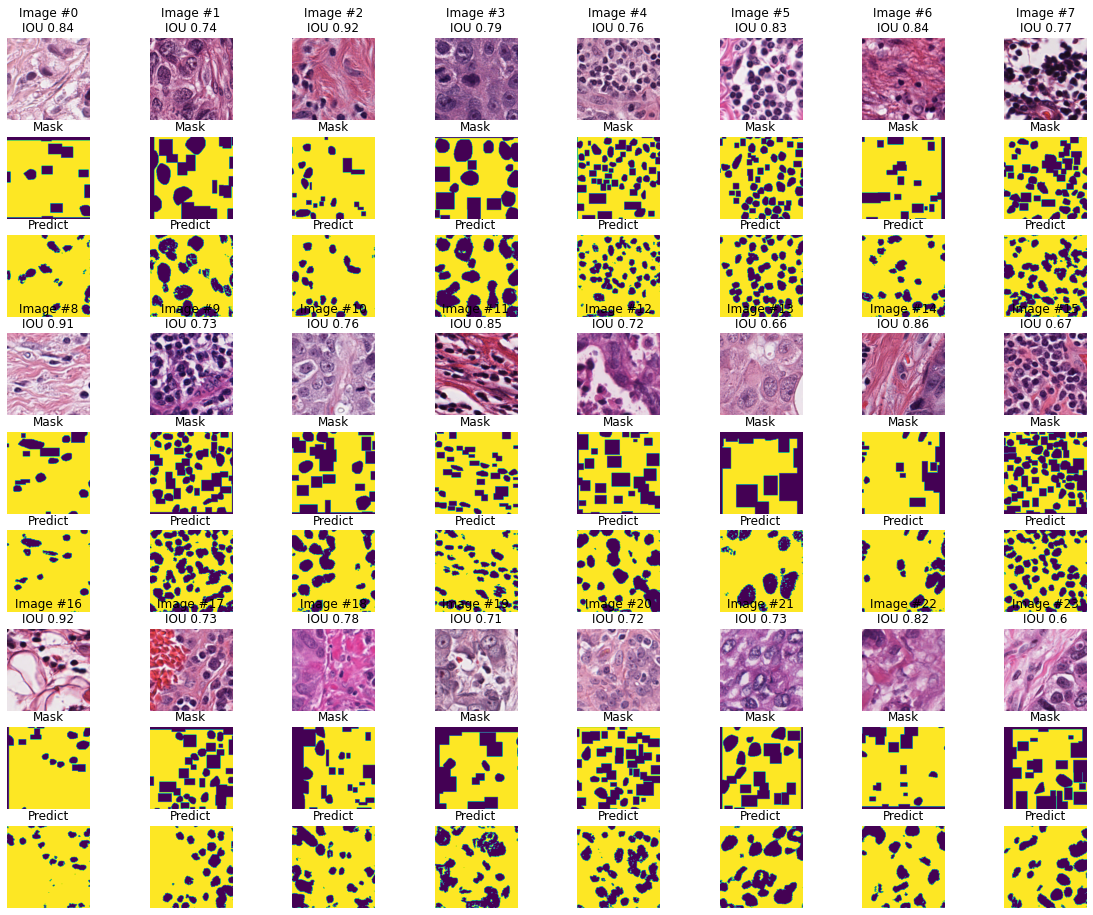

In [19]:
plt.figure(figsize=(20,16))
x, y = 8,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(X_val[pos])
        plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(Y_val[pos]), np.squeeze(preds_val_t[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(Y_val[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_val_t[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()

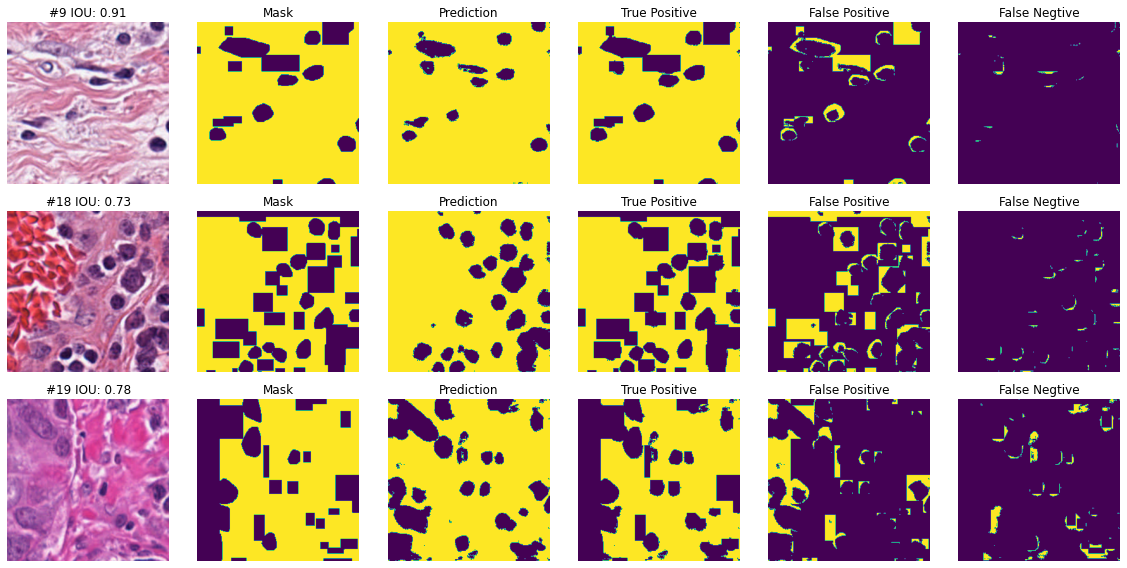

In [20]:
# illustrate the details for some images

ixs = [8,17,18]
plt.figure(figsize=(16,8))
x, y =  6, len(ixs)
for i, ix in enumerate(ixs):  
    # original
    plt.subplot(y,x, i*x+1)
    plt.imshow(X_val[ix])
    plt.title('#{} IOU: {}'.format(ix+1,round(cal_iou(np.squeeze(Y_val[ix]), np.squeeze(preds_val_t[ix])),2)))
    plt.axis('off')
    # grand true
    plt.subplot(y,x, i*x+2)
    plt.imshow(np.squeeze(Y_val[ix]))
    plt.title('Mask')
    plt.axis('off')
    # prediction
    plt.subplot(y,x, i*x+3)
    pred = preds_val_t[ix]>0
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')
    plt.axis('off')
    # true positive
    plt.subplot(y,x, i*x+4)
    fp = np.logical_and(pred, Y_val[ix])  
    plt.imshow(np.squeeze(fp))
    plt.title('True Positive')
    plt.axis('off')   
    # false positive
    plt.subplot(y,x, i*x+5)
    fp = np.logical_and(pred, np.logical_not(Y_val[ix]))  
    plt.imshow(np.squeeze(fp))
    plt.title('False Positive') 
    plt.axis('off')       
    # false negtive
    plt.subplot(y,x, i*x+6)
    fn = np.logical_and(np.logical_not(pred), Y_val[ix]) 
    plt.imshow(np.squeeze(fn))
    plt.title('False Negtive')     
    plt.axis('off')   
plt.tight_layout()
plt.show()

In [21]:
# Use model to predict test labels
Y_hat = model_loaded.predict(X_test, verbose=1)
Y_hat.shape

14/14 [==============================] - 21s 1s/step


(436, 256, 256, 1)

## Visualize predictions on the test data

(256, 256, 3)


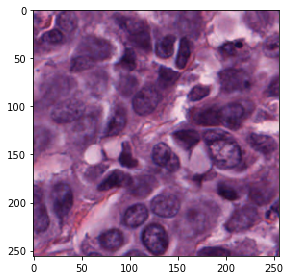

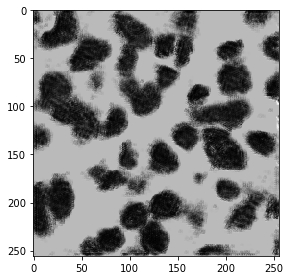

In [22]:
id = 32
print(X_test[id].shape)
skimage.io.imshow(X_test[id])
plt.show()
skimage.io.imshow(Y_hat[id][:,:,0])
plt.show()